# Hierarchical Attentional Hybrid Neural Networks for Document Classification

Document classification is a challenging task with important applications. Deep learning approaches to the problem have gained much attention. Despite the progress, the proposed models do not incorporate the knowledge of the document structure in the architecture efficiently and not take into account the contexting dependent importance of words and sentences. In this paper, we propose a new approach based on convolutional neural networks, gated recurrent units and attention mechanisms for document classification tasks. The datasets IMDB Movie Reviews and Yelp were used in experiments. The proposed method improves the results of current attention-based approaches

Please, cite:

Abreu, J., Fred, L., Macêdo, D., & Zanchettin, C. (2019). Hierarchical Attentional Hybrid Neural Networks for Document Classification. arXiv preprint arXiv:1901.06610.

# Prompts for kaggle username and API key

Displays a field in prompt and waits for the user to input your kaggle username. By press ENTER, other field prompts for input Kaggle API key.

In [1]:
import os
from getpass import getpass

user = getpass('Kaggle Username: ')
key = getpass('Kaggle API key: ')

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle
    
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json

with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json

Kaggle Username: ··········
Kaggle API key: ··········


# Download dataset

In [2]:
!kaggle datasets download -d luisfredgs/hahnn-for-document-classification
!unzip -o hahnn-for-document-classification.zip
# fixing in 400k reviews
!head -n400000 yelp_reviews.json > yelp_reviews_sampling.json

 97% 344M/355M [00:02<00:00, 112MB/s] 
100% 355M/355M [00:02<00:00, 125MB/s]
Archive:  hahnn-for-document-classification.zip
  inflating: imdb_reviews.csv        
  inflating: yelp_reviews.json       


In [0]:
dataset = "yelp" #@param ["yelp", "imdb"]

word_embedding_type = "from_scratch" #@param ["from_scratch", "pre_trained"]
word_vector_model = "fasttext" #@param ["fasttext"]
rnn_type = "GRU" #@param ["LSTM", "GRU"]
learning_rate = 0.001
epochs = 8
batch_size = 64

# Imports

In [4]:
!pip -q install gensim
!python -m spacy download en_core_web_md
!pip -q install paramiko

import datetime, pickle, os, codecs, re, string
import json
import random
import numpy as np
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.utils import CustomObjectScope
from keras.engine.topology import Layer

#
from keras.engine import InputSpec

from keras import initializers

import pandas as pd
from tqdm import tqdm

import string
from spacy.lang.en import English
import gensim, nltk, logging

from nltk.corpus import stopwords
from nltk import tokenize
from nltk.stem import SnowballStemmer

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import en_core_web_sm

from IPython.display import HTML, display

import tensorflow as tf

from numpy.random import seed
from tensorflow import set_random_seed
os.environ['PYTHONHASHSEED'] = str(1024)
set_random_seed(1024)
seed(1024)
np.random.seed(1024)
random.seed(1024)

    100% |████████████████████████████████| 120.9MB 101.2MB/s 
  Running setup.py install for en-core-web-md ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')

    100% |████████████████████████████████| 194kB 7.9MB/s 
    100% |████████████████████████████████| 768kB 25.1MB/s 
    100% |████████████████████████████████| 2.3MB 11.5MB/s 
    100% |████████████████████████████████| 61kB 27.2MB/s 
    100% |████████████████████████████████| 102kB 32.9MB/s 


Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Text preprocessing

In [0]:
def clean_str(string):
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    # string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    # string = re.sub("'", '', string)
    # string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')


    return string.strip().lower()

# Use pre-trained word embeddings

In [0]:
def load_subword_embedding_300d(word_index):
    print('load_subword_embedding...')
    embeddings_index = {}
    f = codecs.open("wiki-news-300d-1M-subword.vec", encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('found %s word vectors' % len(embeddings_index))
    
    #embedding matrix
    print('preparing embedding matrix...')
    words_not_found = []
    
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if (embedding_vector is not None) and len(embedding_vector) > 0:
            
            embedding_matrix[i] = embedding_vector
        else:
            words_not_found.append(word)
    
    return embedding_matrix

# Plot word embedding chart

In [0]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):    
    plt.figure(figsize=(18, 18))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.savefig(filename)

# Normalize texts

In [0]:
nlp = en_core_web_sm.load()


puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '#', '—–']


def clean_puncts(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def remove_stopwords(text):
    text = str(text)    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    text = " ".join(text)
    
    return text


def normalize(text):
    text = text.lower().strip()
    doc = nlp(text)
    filtered_sentences = []
    for sentence in doc.sents:                    
        sentence = clean_puncts(sentence)
        sentence = clean_str(sentence)            
        #sentence = remove_stopwords(sentence)                
        filtered_sentences.append(sentence)
    return filtered_sentences

# Training word embeddings

In [0]:
def create_fasttext(embed_dim, data):
    
    filename = './fasttext_model.txt'
    
    if not os.path.isfile(filename):    
        print('create_fasttext...')
        sent_lst = []

        for doc in data['text']:
            doc = clean_str(doc)
            sentences = nltk.tokenize.sent_tokenize(doc)
            for sent in sentences:
                word_lst = [w for w in nltk.tokenize.word_tokenize(sent) if w.isalnum()]
                sent_lst.append(word_lst)


        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

        fasttext_model = gensim.models.FastText(
            word_ngrams=1,
            sentences=sent_lst, 
            size = embed_dim, 
            workers=os.cpu_count(), 
            window = 1)
        fasttext_model.save("./fasttext_model.txt")

# Load datasets

**1)** Yelp Dataset with 500k reviews

**2)** IMDb with 50k reviews

In [0]:
def load_data_yelp(path, train_ratio=1, size=400000):
    vector_dim = 200
    dim = 5
    
    with open(path) as f:
        reviews=f.read().strip().split("\n")
        
    df = pd.DataFrame([json.loads(review) for review in reviews])        

    text_tokens = []
    for row in tqdm(df['text']):    
        text_tokens.append(normalize(row))  
    
    df['text_tokens'] = text_tokens    
    del text_tokens
    
    vector_dim = 200     
    if word_embedding_type is 'from_scratch':
        create_fasttext(vector_dim, df)
        
    ###
    
    X = df['text_tokens'].values
    Y = pd.get_dummies(df['stars']).values
    
    return (X, Y)

def load_data_imdb(path, size=49000, train_ratio=1):    
    df = pd.read_csv(path, nrows=size, usecols=['text', 'sentiment'])        
    
    vector_dim = 200 
    
    if word_embedding_type is 'from_scratch':
        # Fasttext
        create_fasttext(vector_dim, df)
    
    ### 
    
    text_tokens = []
    for row in tqdm(df['text']):    
        text_tokens.append(normalize(row))  
    
    df['text_tokens'] = text_tokens
    
    del text_tokens
    ###
    
    X = df['text_tokens'].values
    Y = pd.get_dummies(df['sentiment']).values


# Attention Layer
Check [(Bahdanau et al., 2015)](https://arxiv.org/pdf/1409.0473.pdf)

In [0]:
class Attention(Layer):
    def __init__(self, **kwargs):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = 50
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], 1)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(Attention, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)

        if mask is not None:
            ait *= K.cast(mask, K.floatx())
            
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Model architecture

In [0]:
!rm -rf saved_models
!mkdir saved_models

In [0]:
class HAHNetwork():
    def __init__(self):
        self.model = None
        self.MAX_SENTENCE_LENGTH = 0
        self.MAX_SENTENCE_COUNT = 0
        self.VOCABULARY_SIZE = 0
        self.word_embedding = None
        self.model = None
        self.word_attention_model = None
        self.tokenizer = None
        self.class_count = 2

    def build_model(self, n_classes=2, embedding_dim=200, embeddings_path=False):
        
        l2_reg = regularizers.l2(0.001)
        
        embedding_weights = np.random.normal(0, 1, (len(self.tokenizer.word_index) + 1, embedding_dim))
        
        if embeddings_path is not None:

            if word_embedding_type is 'from_scratch':
                # FastText
                filename = './fasttext_model.txt'                
                model =  gensim.models.FastText.load(filename)

                embeddings_index = model.wv                    
                embedding_matrix = np.zeros( ( len(self.tokenizer.word_index) + 1, embedding_dim) )
                for word, i in self.tokenizer.word_index.items():
                    try:
                        embedding_vector = embeddings_index[word]
                        if embedding_vector is not None:
                            embedding_matrix[i] = embedding_vector
                    except Exception as e:
                        #print(str(e))
                        continue


            else:                
                embedding_dim = 300
                embedding_matrix = load_subword_embedding_300d(self.tokenizer.word_index)

            embedding_weights = embedding_matrix

        sentence_in = Input(shape=(self.MAX_SENTENCE_LENGTH,), dtype='int32', name="input_1")
        
        embedding_trainable = True
        
        
        
        if word_embedding_type is 'pre_trained':
            embedding_trainable = False
        
        embedded_word_seq = Embedding(
            self.VOCABULARY_SIZE,
            embedding_dim,
            weights=[embedding_weights],
            input_length=self.MAX_SENTENCE_LENGTH,
            trainable=embedding_trainable,
            #mask_zero=True,
            mask_zero=False,
            name='word_embeddings',)(sentence_in) 
        
        
                     
        dropout = Dropout(0.2)(embedded_word_seq)
        filter_sizes = [3,4,5]
        convs = []
        for filter_size in filter_sizes:
            conv = Conv1D(filters=64, kernel_size=filter_size, padding='same', activation='relu')(dropout)
            pool = MaxPool1D(filter_size)(conv)
            convs.append(pool)
        
        concatenate = Concatenate(axis=1)(convs)
        
        if rnn_type is 'GRU':
            #word_encoder = Bidirectional(CuDNNGRU(50, return_sequences=True, dropout=0.2))(concatenate)                
            dropout = Dropout(0.1)(concatenate)
            word_encoder = Bidirectional(CuDNNGRU(50, return_sequences=True))(dropout)                
        else:
            word_encoder = Bidirectional(
                LSTM(50, return_sequences=True, dropout=0.2))(embedded_word_seq)
            
        
        dense_transform_word = Dense(
            100, 
            activation='relu', 
            name='dense_transform_word', 
            kernel_regularizer=l2_reg)(word_encoder)
        
        # word attention
        attention_weighted_sentence = Model(
            sentence_in, Attention(name="word_attention")(dense_transform_word))
        
        self.word_attention_model = attention_weighted_sentence
        
        attention_weighted_sentence.summary()

        # sentence-attention-weighted document scores
        
        texts_in = Input(shape=(self.MAX_SENTENCE_COUNT, self.MAX_SENTENCE_LENGTH), dtype='int32', name="input_2")
        
        attention_weighted_sentences = TimeDistributed(attention_weighted_sentence)(texts_in)
        
        
        if rnn_type is 'GRU':
            #sentence_encoder = Bidirectional(GRU(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.2))(attention_weighted_sentences)
            dropout = Dropout(0.1)(attention_weighted_sentences)
            sentence_encoder = Bidirectional(CuDNNGRU(50, return_sequences=True))(dropout)
        else:
            sentence_encoder = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.2))(attention_weighted_sentences)
        
        
        dense_transform_sentence = Dense(
            100, 
            activation='relu', 
            name='dense_transform_sentence',
            kernel_regularizer=l2_reg)(sentence_encoder)
        
        # sentence attention
        attention_weighted_text = Attention(name="sentence_attention")(dense_transform_sentence)
        
        
        prediction = Dense(n_classes, activation='softmax')(attention_weighted_text)
        
        model = Model(texts_in, prediction)
        model.summary()
        
        
        optimizer=Adam(lr=learning_rate, decay=0.0001)

        model.compile(
                      optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model


    def get_tokenizer_filename(self, saved_model_filename):
        return saved_model_filename + '.tokenizer'

    def fit_on_texts(self, texts):
        self.tokenizer = Tokenizer(filters='"()*,-/;[\]^_`{|}~', oov_token='UNK');
        all_sentences = []
        max_sentence_count = 0
        max_sentence_length = 0
        for text in texts:
            sentence_count = len(text)
            if sentence_count > max_sentence_count:
                max_sentence_count = sentence_count
            for sentence in text:
                sentence_length = len(sentence)
                if sentence_length > max_sentence_length:
                    max_sentence_length = sentence_length
                all_sentences.append(sentence)


        self.MAX_SENTENCE_COUNT = min(max_sentence_count, 15)
        self.MAX_SENTENCE_LENGTH = min(max_sentence_length, 50)
        
        self.tokenizer.fit_on_texts(all_sentences)
        self.VOCABULARY_SIZE = len(self.tokenizer.word_index) + 1
        self.create_reverse_word_index()

    def create_reverse_word_index(self):
        self.reverse_word_index = {value:key for key,value in self.tokenizer.word_index.items()}

    def encode_texts(self, texts):
        encoded_texts = np.zeros((len(texts), self.MAX_SENTENCE_COUNT, self.MAX_SENTENCE_LENGTH))
        for i, text in enumerate(texts):
            encoded_text = np.array(pad_sequences(
                self.tokenizer.texts_to_sequences(text), 
                maxlen=self.MAX_SENTENCE_LENGTH))[:self.MAX_SENTENCE_COUNT]
            encoded_texts[i][-len(encoded_text):] = encoded_text
        return encoded_texts

    def save_tokenizer_on_epoch_end(self, path, epoch):
        if epoch == 0:
            tokenizer_state = {
                'tokenizer': self.tokenizer,
                'maxSentenceCount': self.MAX_SENTENCE_COUNT,
                'maxSentenceLength': self.MAX_SENTENCE_LENGTH,
                'vocabularySize': self.VOCABULARY_SIZE
            }
            pickle.dump(tokenizer_state, open(path, "wb" ) )

    def train(self, train_x, train_y,
              batch_size=16, 
              epochs=1, 
              embedding_dim=200, 
              embeddings_path=False, 
              saved_model_dir='saved_models', 
              saved_model_filename=None,):
        
        self.fit_on_texts(train_x)
        self.model = self.build_model(
            n_classes=train_y.shape[-1], 
            embedding_dim=200,
            embeddings_path=embeddings_path)
        encoded_train_x = self.encode_texts(train_x)
        callbacks = [
            ReduceLROnPlateau(),
            LambdaCallback(
                on_epoch_end=lambda epoch, logs: self.save_tokenizer_on_epoch_end(
                    os.path.join(saved_model_dir, 
                        self.get_tokenizer_filename(saved_model_filename)), epoch))
        ]

        if saved_model_filename:
            callbacks.append(
                ModelCheckpoint(
                    filepath=os.path.join(saved_model_dir, saved_model_filename),
                    monitor='val_acc',
                    save_best_only=True,
                    save_weights_only=False,
                )
            )
        history = self.model.fit(
                       x=encoded_train_x, 
                       y=train_y, 
                       batch_size=batch_size, 
                       epochs=epochs, 
                       verbose=1, 
                       callbacks=callbacks,
                       validation_split=0.1,  
                       shuffle=True)
        
        # Plot
        print(history.history.keys())
        
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    def encode_input(self, x, log=False):
        x = np.array(x)
        if not x.shape:
            x = np.expand_dims(x, 0)
        texts = np.array([normalize(text) for text in x])
        return self.encode_texts(texts)


# Load dataset

This might take several minutes, depending your dataset

In [14]:
YELP_DATA_PATH = 'yelp_reviews_sampling.json'
IMDB_DATA_PATH = 'imdb_reviews.csv'
SAVED_MODEL_DIR = 'saved_models'
SAVED_MODEL_FILENAME = 'model.h5'

if dataset is 'yelp':
    (X, Y) = load_data_yelp(path=YELP_DATA_PATH, size=400000)
else:
    (X, Y) = load_data_imdb(path=IMDB_DATA_PATH, size=49000)


 61%|██████    | 244394/400000 [3:07:41<1:32:16, 28.10it/s]

Buffered data was truncated after reaching the output size limit.

# Plots Word Embedding chart


2019-04-29 18:54:38,453 : INFO : loading FastText object from ./fasttext_model.txt
2019-04-29 18:54:38,455 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-29 18:54:39,446 : INFO : loading wv recursively from ./fasttext_model.txt.wv.* with mmap=None
2019-04-29 18:54:39,448 : INFO : loading vectors_ngrams from ./fasttext_model.txt.wv.vectors_ngrams.npy with mmap=None
2019-04-29 18:54:39,542 : INFO : setting ignored attribute vectors_norm to None
2019-04-29 18:54:39,544 : INFO : setting ignored attribute vectors_vocab_norm to None
2019-04-29 18:54:39,545 : INFO : setting ignored attribute vectors_ngrams_norm to None
2019-04-29 18:54:39,548 : INFO : setting ignored attribute buckets_word to None
2019-04-29 18:54:39,550 : INFO : loading vocabulary recursively from ./fasttext_model.txt.vocabulary.* with mmap=None
2019-04-29 18:54:39,553 : INFO : loading trainables recursively from ./fasttext_model.txt.trainables.* with mmap=None
2019-04-29 18:54:39,559 : INFO : l

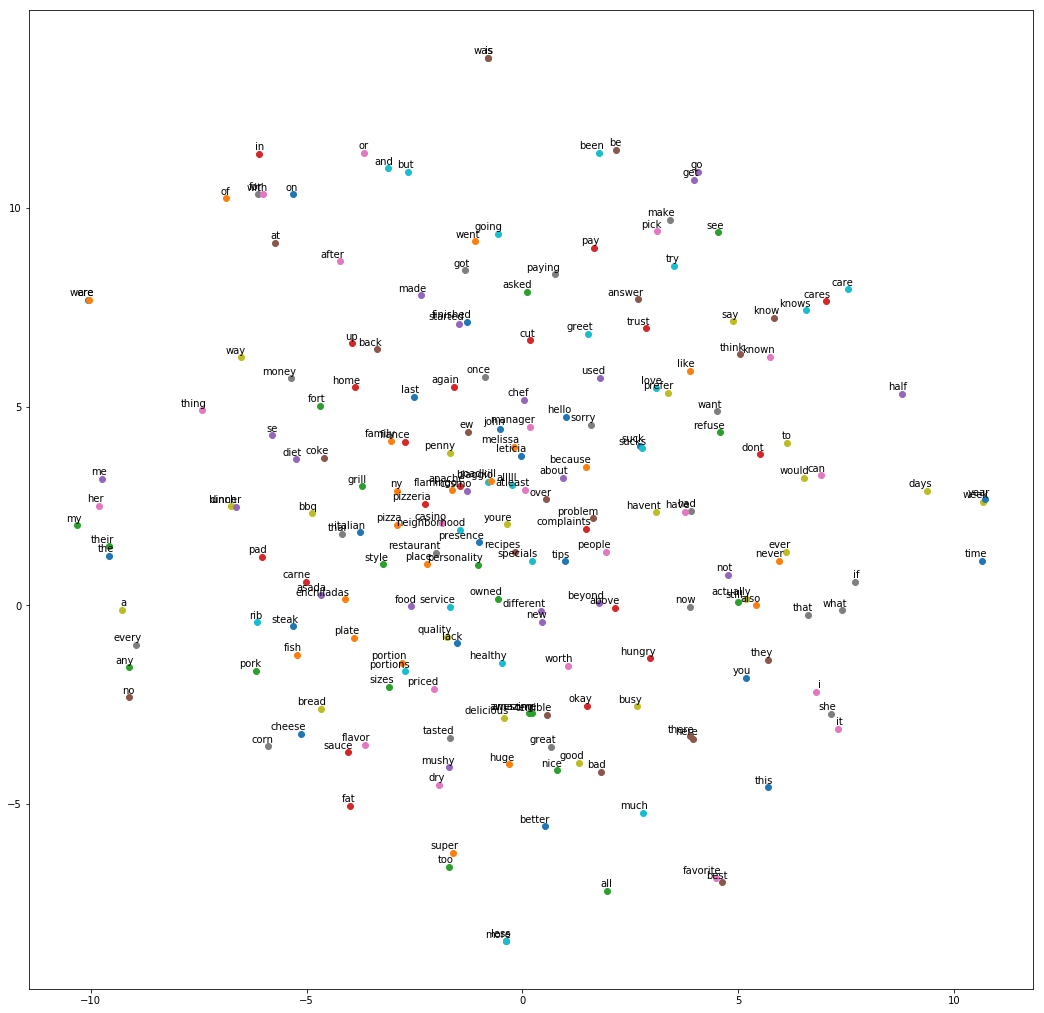

In [15]:
limit = 200
vector_dim = 200

# Fasttext
filename = './fasttext_model.txt'                
model =  gensim.models.FastText.load(filename)
words = []
embedding = np.array([])
i = 0
for word in model.wv.vocab:
    if i == limit: break

    words.append(word)
    embedding = np.append(embedding, model[word])
    i += 1

embedding = embedding.reshape(limit, vector_dim)    
tsne = TSNE(n_components=2)
low_dim_embedding = tsne.fit_transform(embedding)
       
plot_with_labels(low_dim_embedding, words)


# Taining model

2019-04-29 18:55:44,843 : INFO : loading FastText object from ./fasttext_model.txt
2019-04-29 18:55:44,845 : WARNING : this function is deprecated, use smart_open.open instead
2019-04-29 18:55:45,983 : INFO : loading wv recursively from ./fasttext_model.txt.wv.* with mmap=None
2019-04-29 18:55:45,984 : INFO : loading vectors_ngrams from ./fasttext_model.txt.wv.vectors_ngrams.npy with mmap=None
2019-04-29 18:55:46,086 : INFO : setting ignored attribute vectors_norm to None
2019-04-29 18:55:46,087 : INFO : setting ignored attribute vectors_vocab_norm to None
2019-04-29 18:55:46,088 : INFO : setting ignored attribute vectors_ngrams_norm to None
2019-04-29 18:55:46,090 : INFO : setting ignored attribute buckets_word to None
2019-04-29 18:55:46,090 : INFO : loading vocabulary recursively from ./fasttext_model.txt.vocabulary.* with mmap=None
2019-04-29 18:55:46,091 : INFO : loading trainables recursively from ./fasttext_model.txt.trainables.* with mmap=None
2019-04-29 18:55:46,092 : INFO : l

Instructions for updating:
Colocations handled automatically by placer.


2019-04-29 18:55:54,856 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2019-04-29 18:55:55,680 : WARNING : From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
word_embeddings (Embedding)     (None, 50, 200)      34060400    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 50, 200)      0           word_embeddings[0][0]            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 50, 64)       38464       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (

2019-04-29 18:57:12,243 : WARNING : From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 360000 samples, validate on 40000 samples
Epoch 1/8
360000/360000 [==============================] - 483s 1ms/step - loss: 0.7650 - acc: 0.6915 - val_loss: 0.6750 - val_acc: 0.7219
Epoch 2/8
360000/360000 [==============================] - 463s 1ms/step - loss: 0.6592 - acc: 0.7261 - val_loss: 0.6380 - val_acc: 0.7350
Epoch 3/8
360000/360000 [==============================] - 471s 1ms/step - loss: 0.6282 - acc: 0.7372 - val_loss: 0.6300 - val_acc: 0.7371
Epoch 4/8
360000/360000 [==============================] - 466s 1ms/step - loss: 0.6064 - acc: 0.7467 - val_loss: 0.6246 - val_acc: 0.7412
Epoch 5/8
360000/360000 [==============================] - 466s 1ms/step - loss: 0.5894 - acc: 0.7545 - val_loss: 0.6269 - val_acc: 0.7414
Epoch 6/8
360000/360000 [==============================] - 466s 1ms/step - loss: 0.5767 - acc: 0.7605 - val_loss: 0.6254 - val_acc: 0.7409
Epoch 7/8
360000/360000 [==============================] - 465s 1ms/step - loss: 0.5646 - acc: 0.7659 - val_loss: 0

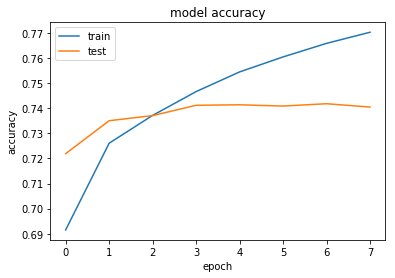

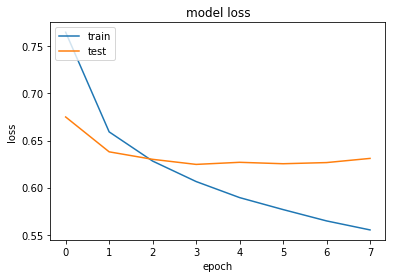

In [16]:
K.clear_session()
model = HAHNetwork()
model.train(X, Y, batch_size=64, epochs=8, embeddings_path=True, saved_model_dir=SAVED_MODEL_DIR, saved_model_filename=SAVED_MODEL_FILENAME)